<a href="https://colab.research.google.com/github/Nikkyzzzz/major-Project/blob/main/notebooks/Lung_Cancer_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Information**
%%html
<marquee style='width: 50%; color: white;'><b>Dylan Govender (221040222) - COMP700</b></marquee>

# **1. Importing the data.**

In [5]:
!cp '/content/drive/MyDrive/Honours Project/Datasets/IQ-OTHNCCD_Lung_Cancer_Dataset.zip' 'IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

In [6]:
%%capture
!unzip '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!rm '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

normal_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Normal cases"
benign_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
dir = [normal_dir, benign_dir, malignant_dir]

class_labels = ['benign', 'malignant', 'normal']

labels = []
filepaths = []

for i, directory in enumerate(dir):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        filepaths.append(filepath)
        labels.append(class_labels[i])

file_series = pd.Series(filepaths, name="filepaths")
label_series = pd.Series(labels, name="labels")
lung_data = pd.concat([file_series, label_series], axis=1)
lung_df = pd.DataFrame(lung_data)
lung_df.head()

,filepaths,labels
0,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
1,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
2,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
3,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
4,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign


In [8]:
print(lung_df["labels"].value_counts())
print("SHAPE:", lung_df.shape)

labels
normal       561
benign       416
malignant    120
Name: count, dtype: int64
SHAPE: (1097, 2)


# **2. Preprocessing the data.**

In [9]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

train_set, remaining = train_test_split(lung_df, test_size=0.4, random_state=42)
test_set, val_set = train_test_split(remaining, test_size=0.5, random_state=42)

data = [
    ["Train", train_set.shape],
    ["Test", test_set.shape],
    ["Validate", val_set.shape],
]

X_table = tabulate(data, headers=["SETS", "Shape"], tablefmt="fancy_grid")
print(X_table)

╒══════════╤══════════╕
│ SETS     │ Shape    │
╞══════════╪══════════╡
│ Train    │ (658, 2) │
├──────────┼──────────┤
│ Test     │ (219, 2) │
├──────────┼──────────┤
│ Validate │ (220, 2) │
╘══════════╧══════════╛


In [10]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)

train = image_generator.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical", # used for sequential model
    batch_size=4,
    shuffle=False, # do not shuffle data
)

test = image_generator.flow_from_dataframe(
    dataframe=test_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=4,
    shuffle=False,
)

val = image_generator.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=4,
    shuffle=False,
)

Found 658 validated image filenames belonging to 3 classes.
Found 219 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [11]:
classes = list(train.class_indices.keys())
print(classes)

['benign', 'malignant', 'normal']


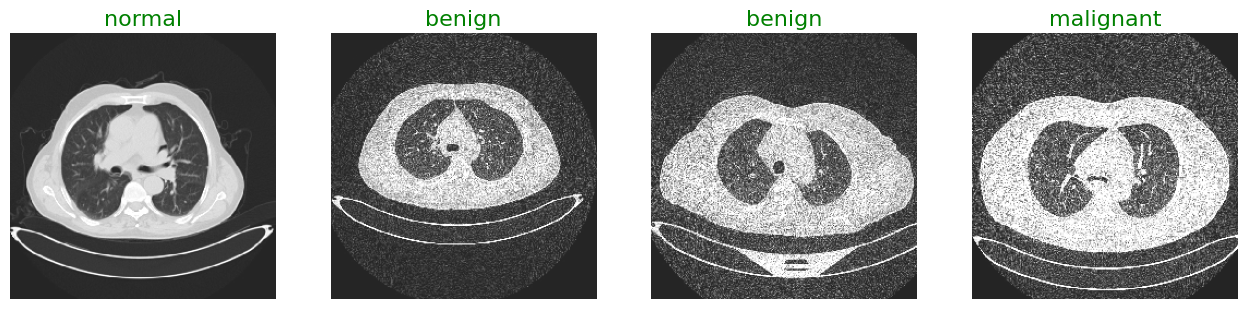

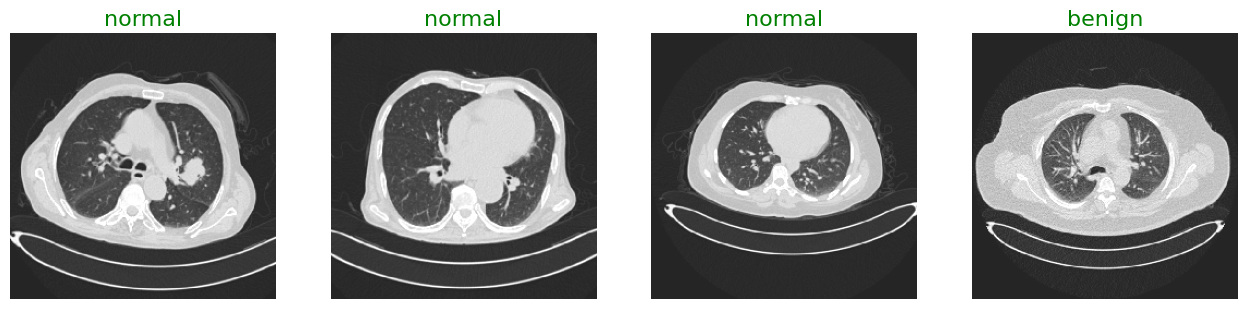

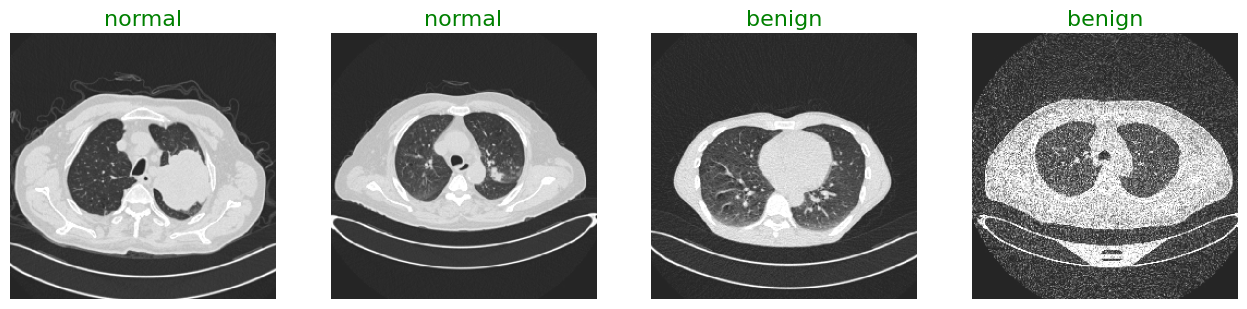

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(image_gen):
    classes = list(test.class_indices.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))

    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] + 1) / 2)
        plt.title(classes[np.argmax(labels[i])], color="green", fontsize=16)
        plt.axis('off')

    plt.show()

display_sample_images(train)
display_sample_images(test)
display_sample_images(val)

# **3. Building the CNN Model.**

In [23]:
import tensorflow
import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

model = Sequential(name="CNN")
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

LEARNING_RATE = 0.001

# Custom F1 Score metric
@keras.saving.register_keras_serializable()
class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=['accuracy', Precision(name='precision'), Recall(), F1Score(), AUC()]
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 12, 12, 512)         │           2,0

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

## **3.1 Model Architecture: CNN**

In [14]:
# saving model data
MODEL_NUMBER = 1
MODEL_NAME = 'CNN_Model'
MODEL_FULL = MODEL_NAME + '_' + str(MODEL_NUMBER)

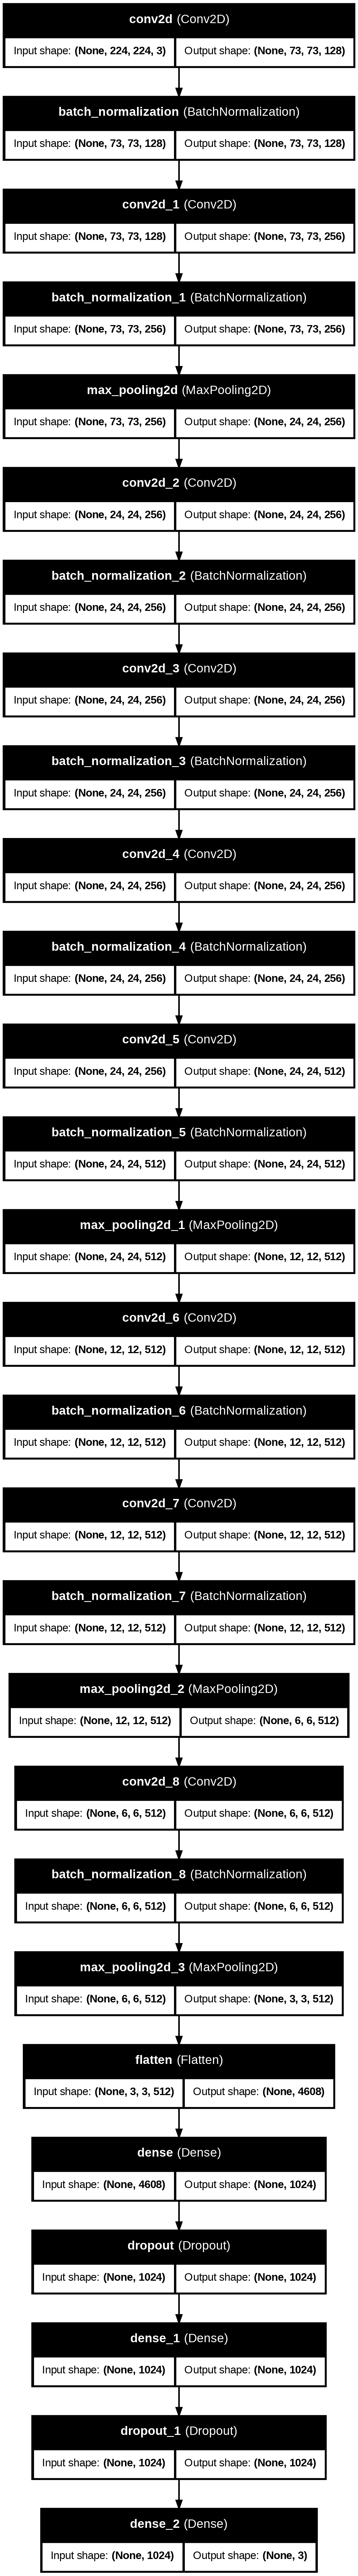

In [15]:
from tensorflow.keras.utils import plot_model

save_plot = MODEL_FULL + '_model_plot.png'

# Plot the model architecture with a lower DPI for a smaller image
plot_model(model, to_file=save_plot, show_shapes=True, show_layer_names=True, expand_nested=False)

# **4. Training the CNN Model.**

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_FULL + '_best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# fit the model - training
history=model.fit(train,validation_data=val,epochs=30,verbose=1,callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard],)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 1.0000 - auc_3: 1.0000 - f1_score: 1.0000 - loss: 0.0105 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9500 - val_auc_3: 0.9967 - val_f1_score: 0.9522 - val_loss: 0.1224 - val_precision_4: 0.9543 - val_recall_4: 0.9500 - learning_rate: 1.0000e-11
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9995 - auc_3: 1.0000 - f1_score: 0.9995 - loss: 0.0081 - precision_4: 0.9995 - recall_4: 0.9995 - val_accuracy: 0.9500 - val_auc_3: 0.9967 - val_f1_score: 0.9522 - val_loss: 0.1237 - val_precision_4: 0.9543 - val_recall_4: 0.9500 - learning_rate: 1.0000e-11
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9952 - auc_3: 1.0000 - f1_score: 0.9952 - loss: 0.0174 - precision_4: 0.9952 - recall_4: 0.9952 - val_accuracy: 0.9500 - val_auc_3: 0.9967 - val_f1_score: 0.9522 - val_loss: 0.1236 - val_precision_4: 0.9543 - val_recall_4: 0.9500 - learning_rate: 1.0000e-11
Epoch 4/30
165/165 ━━━

In [35]:
print(history.history.keys())


dict_keys(['accuracy', 'auc_3', 'f1_score', 'loss', 'precision_4', 'recall_4', 'val_accuracy', 'val_auc_3', 'val_f1_score', 'val_loss', 'val_precision_4', 'val_recall_4', 'learning_rate'])


## **5.1 Performance Graphs**

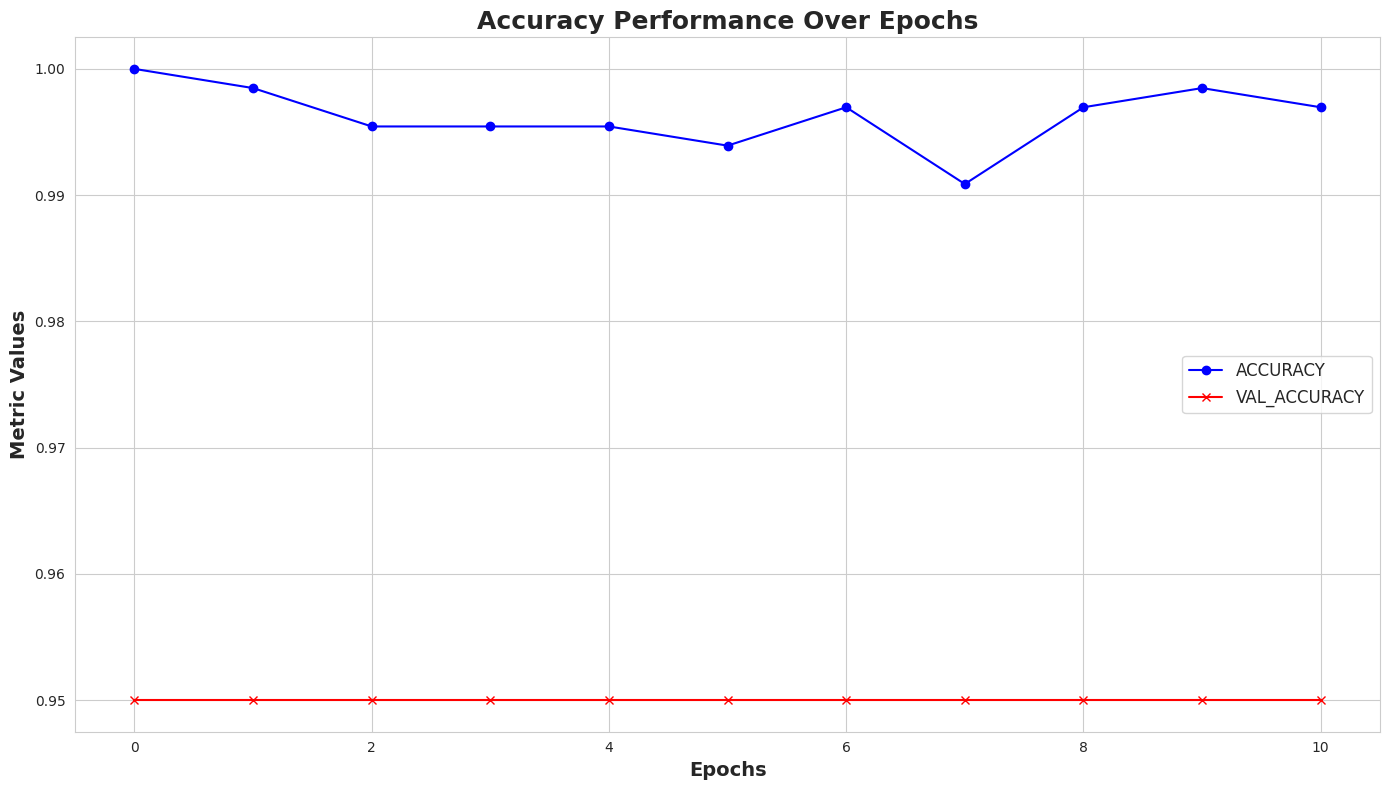

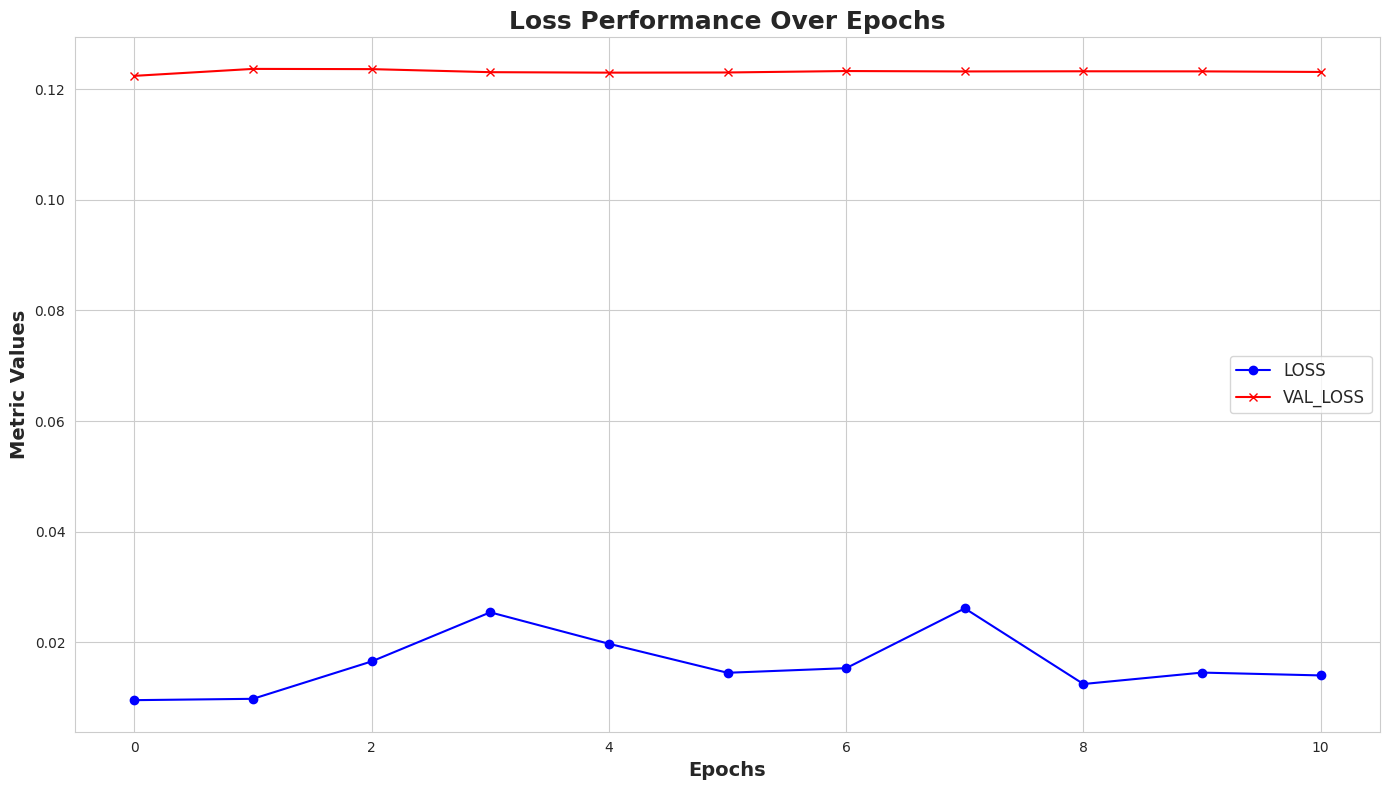

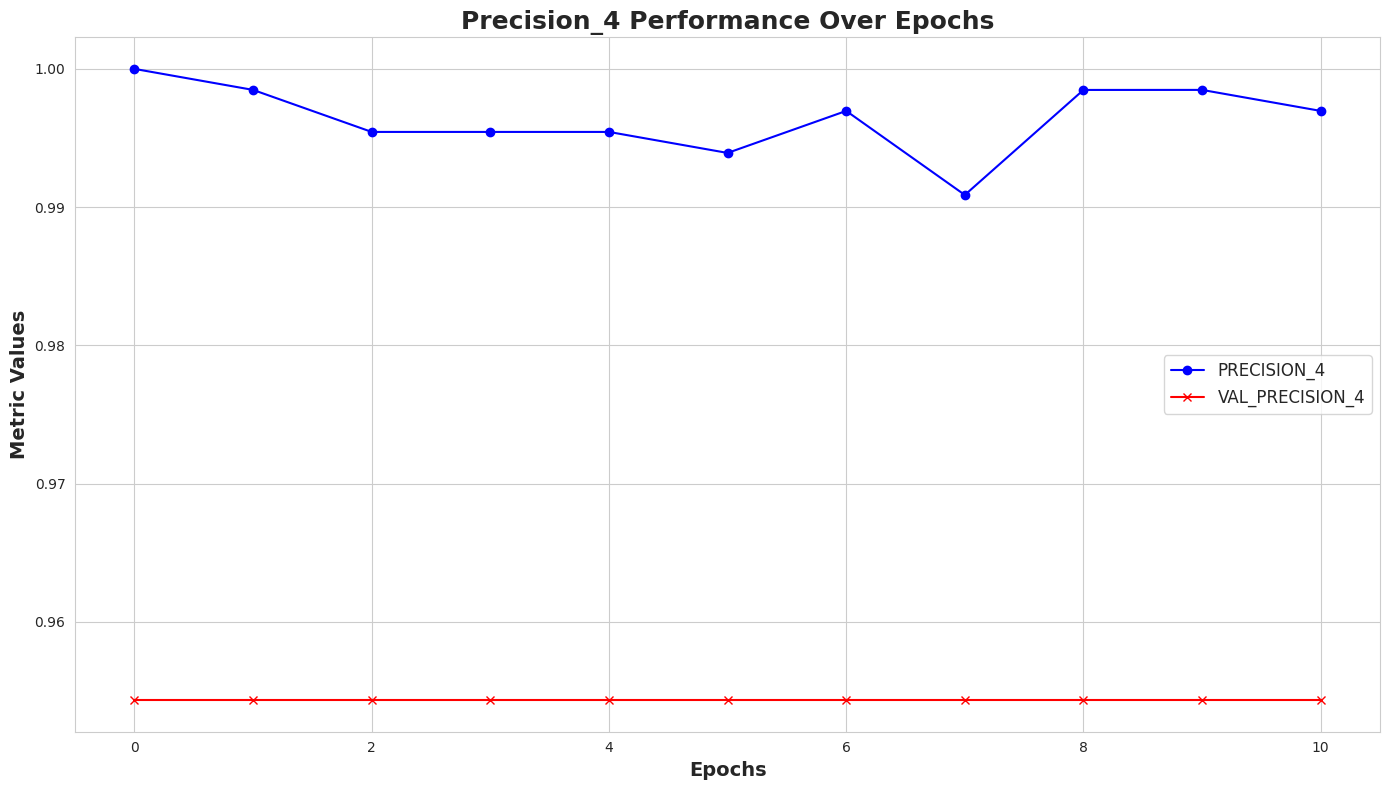

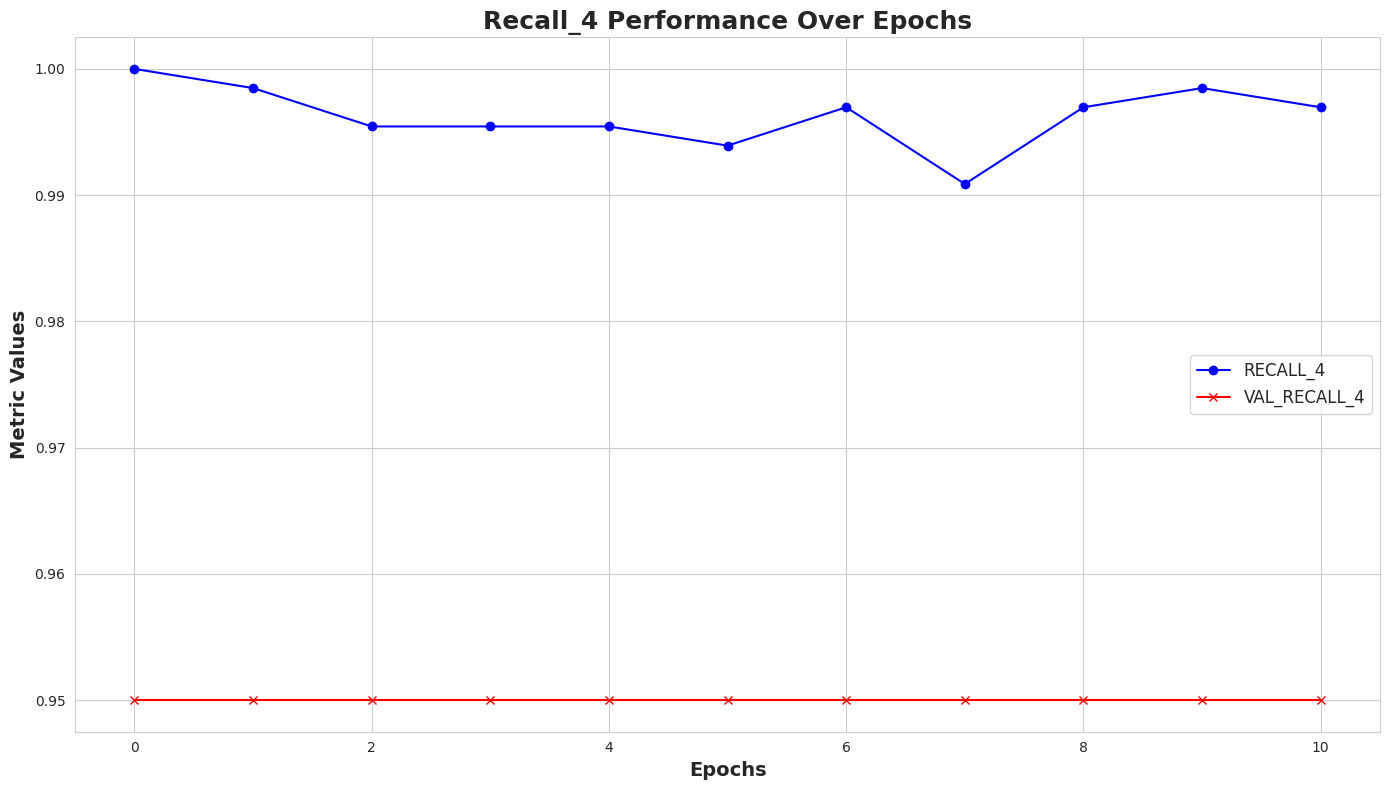

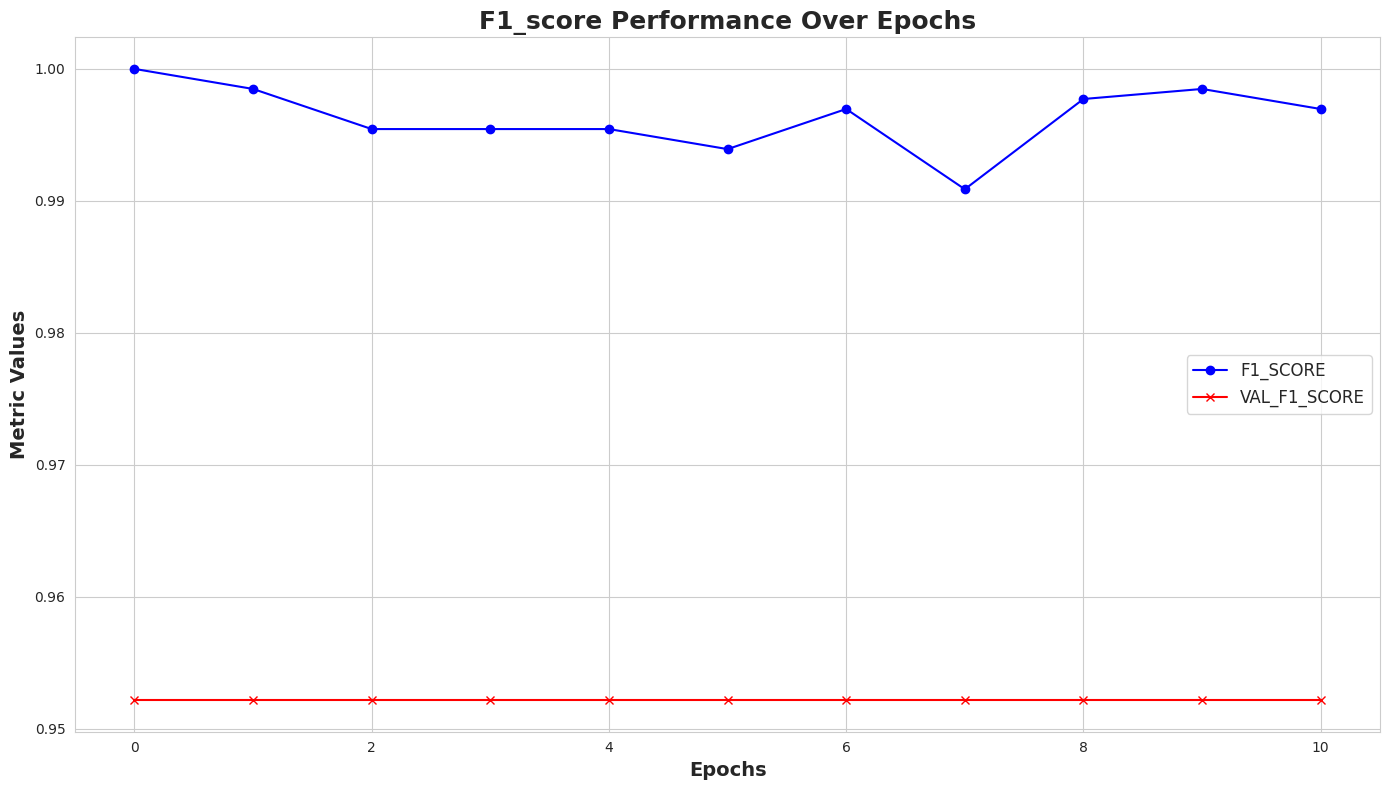

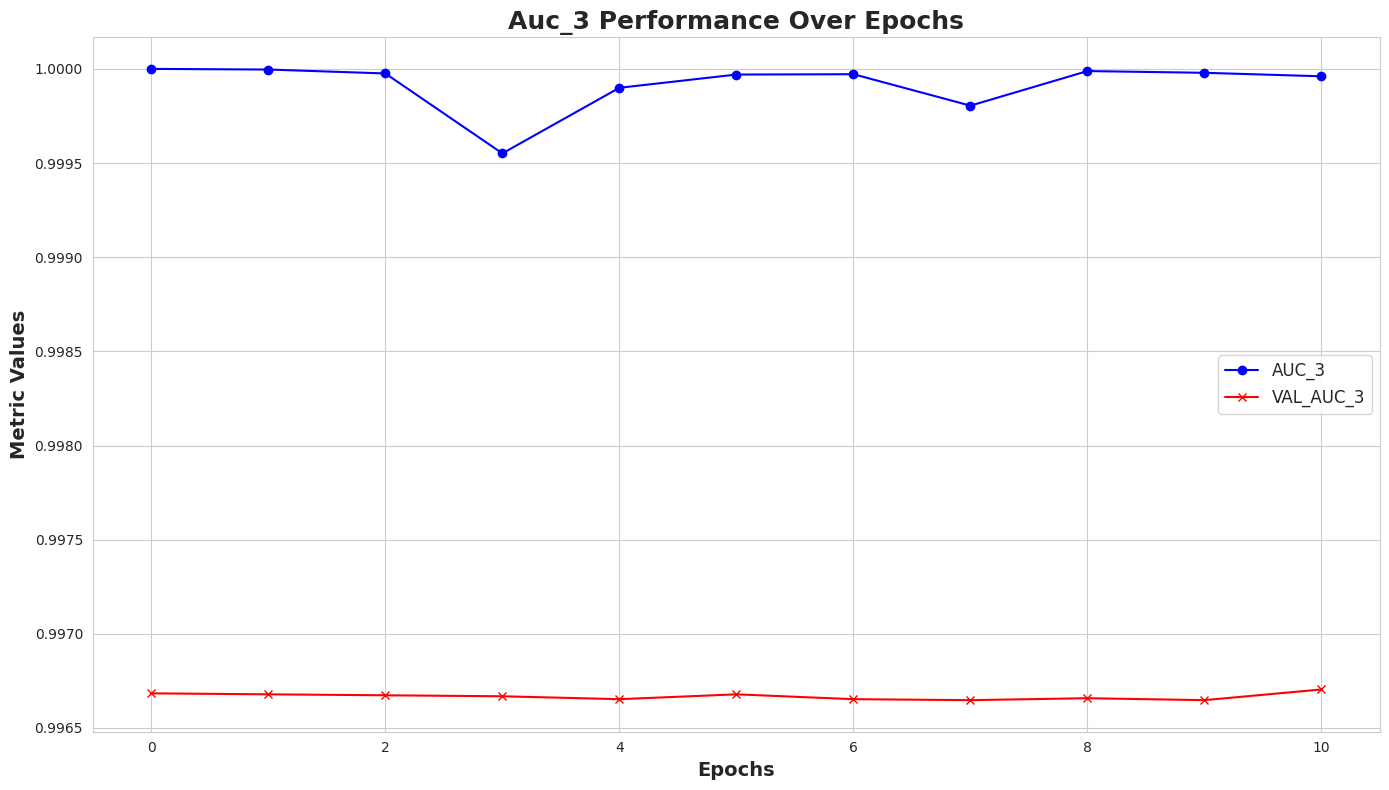

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, metric, title):
    val_metric = "val_" + metric
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 8))
    plt.plot(history.history[metric], label=metric.upper(), linestyle='-', marker='o', color='blue')
    plt.plot(history.history[val_metric], label=val_metric.upper(), linestyle='-', marker='x', color='red')
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Metric Values', fontsize=14, fontweight='bold')
    plt.title(metric.capitalize() + title, fontsize=18, fontweight='bold')
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

metrics = ['accuracy', 'loss', 'precision_4', 'recall_4', 'f1_score', 'auc_3']
for metric in metrics:
    print()
    plot_training_history(history, metric, title=' Performance Over Epochs')

# **5. Evaluating the CNN Model.**

In [37]:
model.save(MODEL_FULL + ".keras")

In [39]:
from tensorflow.keras.models import load_model

# Load the entire model from a .keras file
model = load_model(MODEL_FULL + '.keras')

# Evaluate the model on the test dataset
results = model.evaluate(test, verbose=1)

# Print the results dynamically based on the model's metrics
metrics_names = model.metrics_names  # Get metric names from the model
for name, value in zip(metrics_names, results):
    print(f"{name}: {value}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9851 - auc_3: 0.9993 - f1_score: 0.9871 - loss: 0.0446 - precision_4: 0.9891 - recall_4: 0.9851
loss: 0.06752417236566544
compile_metrics: 0.9817351698875427


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


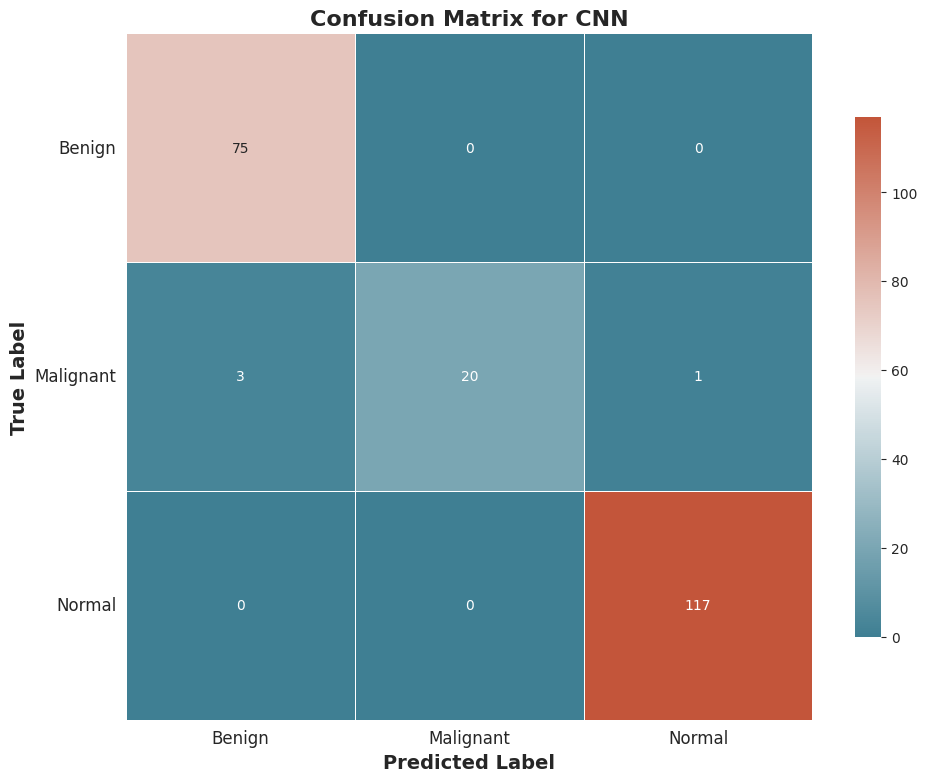

<Figure size 640x480 with 0 Axes>

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predict on the test set
test_steps = test.samples // test.batch_size
y_pred = model.predict(test, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test.classes
y_true = y_true[:len(y_pred)]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Set the figure size and resolution
plt.figure(figsize=(10, 8), dpi=100)

# Create a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the confusion matrix heatmap
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75},
    xticklabels=[label.capitalize() for label in test.class_indices.keys()],
    yticklabels=[label.capitalize() for label in test.class_indices.keys()]
)

# Add labels and title with increased font size
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix for CNN', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()
plt.savefig(MODEL_FULL + '_Confusion_Matrix_Heatmap.png', format='png', dpi=300)

In [ ]:
# zip the important folders
!zip -r /content/CNN_Model_1.zip /content/CNN_Model_1.keras
!zip -r /content/CNN_Model_1_best_model.zip /content/CNN_Model_1_best_model.keras
!zip -r /content/CNN_Model_1_logs.zip /content/logs

# download the zipped folders
from google.colab import files
files.download('/content/CNN_Model_1.zip')
files.download('/content/CNN_Model_1_logs.zip')
files.download('/content/CNN_Model_1_best_model.zip')
files.download('/content/CNN_Model_1_model_plot.png')
files.download('/content/CNN_Model_1_Confusion_Matrix_Heatmap.png')

  adding: content/CNN_Model_1.keras (deflated 9%)
  adding: content/CNN_Model_1_best_model.keras (deflated 9%)
  adding: content/logs/ (stored 0%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1724842399.71088adc4455.516.1.v2 (deflated 79%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1724842364.71088adc4455.516.0.v2 (deflated 69%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>